# Example #3 Housing Prediction: Chapter 3

Example of regression.

In [1]:
import pandas as pd
import numpy as np

from keras import models
from keras import layers
from keras import optimizers

import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import boston_housing

Using TensorFlow backend.


# Load Data

In [2]:
# Get the feature names from the original dataset description.

# http://lib.stat.cmu.edu/datasets/boston
variable_description = """
     CRIM     per capita crime rate by town
     ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
     INDUS    proportion of non-retail business acres per town
     CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
     NOX      nitric oxides concentration (parts per 10 million)
     RM       average number of rooms per dwelling
     AGE      proportion of owner-occupied units built prior to 1940
     DIS      weighted distances to five Boston employment centres
     RAD      index of accessibility to radial highways
     TAX      full-value property-tax rate per $10,000
     PTRATIO  pupil-teacher ratio by town
     B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
     LSTAT    % lower status of the population
     MEDV     Median value of owner-occupied homes in $1000's
"""

variables = []
for line in variable_description.split("\n"):
    parts = line.strip().split()
    if len(parts) >= 1:
        variables.append(parts[0])
        
def make_df(data, targets):
    df = pd.DataFrame(data=data, columns=variables[0:13])
    df[variables[13]] = targets
    return df

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data_df = make_df(train_data, train_targets)
test_data_df = make_df(test_data, test_targets)

## Explore Data

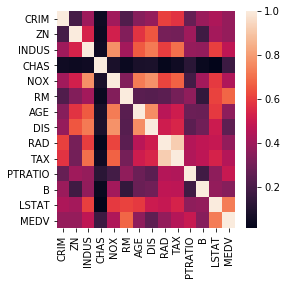

In [4]:
# View feature correlation

td_corr = train_data_df.corr().abs()
plt.figure(figsize = (4,4))
sns.heatmap(td_corr, annot=False)
plt.show()

In [5]:
td_corr[['MEDV']].sort_values(by='MEDV', ascending=False).head(10)

,MEDV
MEDV,1.000000
LSTAT,0.730793
RM,0.681483
PTRATIO,0.493990
INDUS,0.476743
TAX,0.448737
NOX,0.438328
ZN,0.380299
CRIM,0.378498
RAD,0.375515


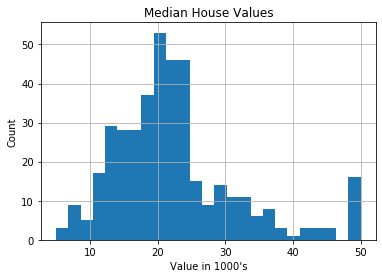

In [6]:
plt.hist(train_targets, bins=25)
plt.title("Median House Values")
plt.xlabel("Value in 1000's")
plt.ylabel("Count")
plt.grid()
plt.show()

## Prepare Data

In [7]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

def normalize(data):
    return (data - mean) / std

train_data_df_norm = normalize(train_data_df.loc[:,variables[0:13]])
train_data_df_norm[variables[13]] = train_data_df[variables[13]]

test_data_df_norm = normalize(test_data_df.loc[:,variables[0:13]])
test_data_df_norm[variables[13]] = test_data_df[variables[13]]

## Train Model

In [8]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(len(variables) - 1,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [9]:
k = 4
train_data_df_norm['k'] = [i % k for i in train_data_df_norm.index.values]
num_epochs = 200

histories = []

for i in train_data_df_norm.k.unique():
    print('processing fold #', i)
    
    train_data = train_data_df_norm[train_data_df_norm.k != i]
    val_data = train_data_df_norm[train_data_df_norm.k == i]
    
    train_x = train_data[variables[0:13]]
    train_y = train_data[variables[13]]
    val_x = val_data[variables[0:13]]
    val_y = val_data[variables[13]]
    
    model = build_model()
    history = model.fit(
        train_x,
        train_y,
        epochs=num_epochs,
        batch_size=1,
        verbose=0,
        validation_data=(val_x, val_y)
    )
    histories.append(history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [10]:
def history_to_df(h):
    h_df = pd.DataFrame(h.history)
    h_df['epoch'] = h_df.index.values + 1
    return h_df

history = pd.concat(history_to_df(h) for h in histories)
h_avgs = history.groupby('epoch').mean()

In [11]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

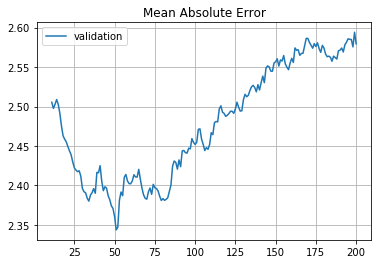

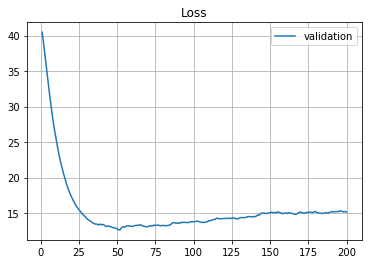

In [12]:
#plt.plot(h_avgs.index[10:], smooth_curve(h_avgs.mae[10:]), "-", label="train")
plt.plot(h_avgs.index[10:], smooth_curve(h_avgs.val_mae[10:]), "-", label="validation")
plt.grid()
plt.title("Mean Absolute Error")
plt.legend()
plt.show()

#plt.plot(h_avgs.index, h_avgs.loss, "-", label="train")
plt.plot(h_avgs.index, smooth_curve(h_avgs.val_loss), "-", label="validation")
plt.grid()
plt.title("Loss")
plt.legend()
plt.show()

## Train Model

In [13]:
model = build_model()
num_epochs = 80
model.fit(
    train_data_df_norm[variables[0:13]],
    train_data_df_norm[variables[13]],
    epochs=num_epochs,
    batch_size=1,
    verbose=0
)

## Evaluate Test Results

In [14]:
val_mse, val_mae = model.evaluate(
    test_data_df_norm[variables[0:13]],
    test_data_df_norm[variables[13]],
    verbose=0)

print(val_mse)
print(val_mae)

15.688272214403339
2.5668604373931885


In [15]:
test_data_df['Predicted'] = [r[0] for r in model.predict(test_data_df_norm[variables[0:13]])]

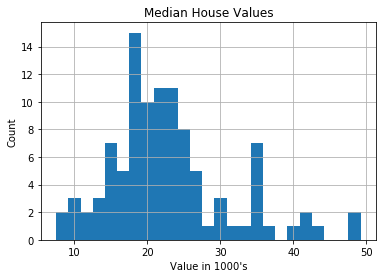

In [16]:
plt.hist(test_data_df.Predicted, bins=25)
plt.title("Median House Values")
plt.xlabel("Value in 1000's")
plt.ylabel("Count")
plt.grid()
plt.show()

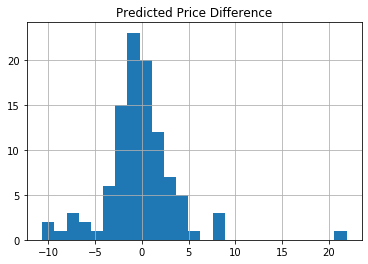

In [26]:
plt.hist(test_data_df.Predicted - test_data_df.MEDV, bins=25)
plt.title("Predicted Price Difference")
plt.grid()
plt.show()

## See How XGBoost Compares

In [17]:
import xgboost as xgb
import sklearn.metrics

In [18]:
xgb_model = xgb.XGBRegressor(
    objective ='reg:squarederror',
    learning_rate = 0.2,
    max_depth = 5,
    alpha = 5,
    n_estimators = 20
)

train_x_part = train_data_df_norm

xgb_model.fit(
    train_data_df_norm[variables[0:13]],
    train_data_df_norm[variables[13]]
)

xgb_results = xgb_model.predict(train_data_df_norm[variables[0:13]])

mae = sklearn.metrics.mean_absolute_error(train_data_df_norm[variables[13]], xgb_results)
print(f"Mean Absolute Error: {mae}")

xgb_t_results = xgb_model.predict(test_data_df_norm[variables[0:13]])
t_mae = sklearn.metrics.mean_absolute_error(test_data_df_norm[variables[13]], xgb_t_results)
print(f"Test Mean Absolute Error: {t_mae}")

Mean Absolute Error: 1.0518234802944826
Test Mean Absolute Error: 2.5680659668118344


c:\users\bryan\source\rook_keras_learn\venv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\bryan\source\rook_keras_learn\venv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [19]:
features = pd.DataFrame()
features['name'] = variables[0:13]
features['importance'] = xgb_model.feature_importances_
features = features.sort_values(by='importance', ascending=False)
features

,name,importance
12,LSTAT,0.630532
5,RM,0.162426
7,DIS,0.053833
4,NOX,0.037978
0,CRIM,0.032994
9,TAX,0.022079
10,PTRATIO,0.016418
2,INDUS,0.011400
11,B,0.011233
8,RAD,0.008622


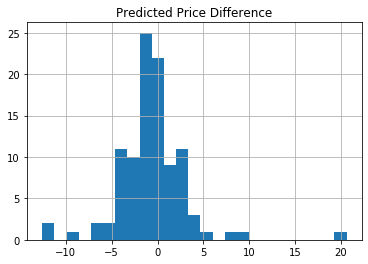

In [25]:
plt.hist(xgb_t_results - test_data_df.MEDV, bins=25)
plt.title("Predicted Price Difference")
plt.grid()
plt.show()